/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
Covid_hosp shape (5129, 3)
Search trends shape (608, 430)
Number of symptoms removed: 407
422
% OF SYMPTOMS REMOVED:  96.44549763033176
/opt/venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


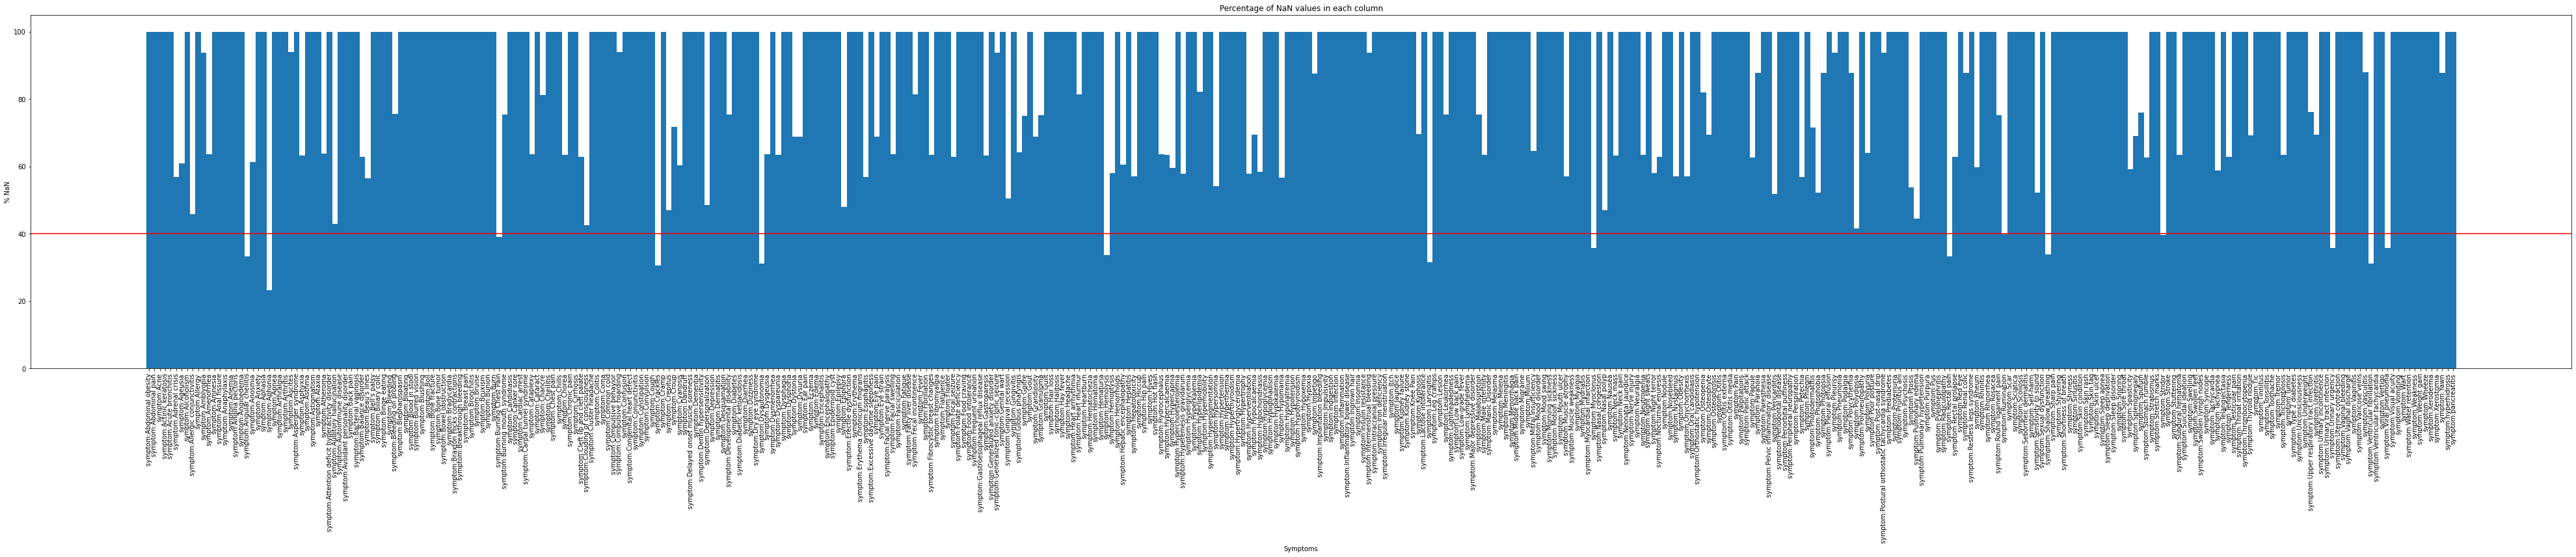

In [5]:
# TASK 1

import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Want to predit hospitalized_new
#We then find the maximum value of the normalized popularity across the entire published time range for that region, over all symptoms using the chosen time resolution (day/week). 
#We scale this maximum value to 100. 
#All the other values are mapped to proportionally smaller values (linear scaling) in the range 0-100.
#For example, in the weekly data the row labeled 2020-07-13 represents the search activity for the week of July 13 to July 19, 2020, inclusive.
# The COVID_hosp dataset starts at 2019-12-31, while the search_trends starts on 01-06 -> drop 1st 7 rows of COVID_hosp

# For new cases, take sum
# NEED TO CHANGE IT SO THAT IT MERGES EVERY 7 ENTRIES UNTIL THE END OF THE REGION CODE! WHEN IT STOPS!
# also there may not be an even number of entries...may not be divisible by 7

hosp_data = pd.read_csv("COVID_hospitalization_cases_2020-10-04.csv")
search_data = pd.read_csv("search_trends_2020-10-04.csv")
search_data['date'] =  pd.to_datetime(search_data['date'], format='%Y-%m-%d')
search_data.open_covid_region_code = search_data.open_covid_region_code.astype(str)

temp = hosp_data[['open_covid_region_code', 'date','hospitalized_new']].copy()
temp['date'] =  pd.to_datetime(temp['date'], format='%Y-%m-%d')
temp.open_covid_region_code = temp.open_covid_region_code.astype(str)

reg_codes = temp.open_covid_region_code.unique()
covid_hosp = pd.DataFrame()

search_start_week = {}
rc = ""

for index, row in search_data.iterrows():
    if row["open_covid_region_code"] != rc:
        rc = row["open_covid_region_code"]
        search_start_week[rc] = row["date"] 

rc = ""
hosp_start_week = {}
for index, row in temp.iterrows():
    if row["open_covid_region_code"] != rc:
        rc = row["open_covid_region_code"]
        hosp_start_week[rc] = row["date"]

for r in search_start_week.keys():
    while search_start_week[r] != hosp_start_week[r]:
        # search is by week +7
        # hosp is by day +1
        if search_start_week[r] > hosp_start_week[r]:
            hosp_start_week[r] += datetime.timedelta(days=1)
        else:
            search_start_week[r] += datetime.timedelta(days=7)

# now all dates should be equal

for reg in reg_codes:
    region = temp[temp.open_covid_region_code == reg]
    region = region[region.date >= hosp_start_week[reg]]
    region = region.reset_index(drop=True)
    count_nan = len(region.hospitalized_new) - region.hospitalized_new.count()
    if count_nan == len(region.hospitalized_new):
        continue
        # so ignoring the regions that have no hospitalized_new data at all
    region_hosp = region.hospitalized_new.copy()
    region = region.drop('hospitalized_new', axis=1)
    region = region.iloc[::7]
    region_hosp = region_hosp.groupby(region_hosp.index // 7).sum()
    region = region.reset_index(drop=True)
    region_hosp = region_hosp.reset_index(drop=True)
    region = pd.concat([region, region_hosp], axis=1, sort=False)
    covid_hosp = covid_hosp.append(region)

covid_hosp = covid_hosp.reset_index(drop=True)
print("Covid_hosp shape", covid_hosp.shape)



#column_locs = {hosp_data.columns.get_loc(c): c for idx, c in enumerate(hosp_data.columns)}
#print(column_locs)


covid_hosp.to_csv('covid_hosp.csv', sep=",")

print("Search trends shape", search_data.shape)

# Normalizing clean_search_data.csv by medians across the whole region
# Joining two datasets

symptom_nan_count = []
symptoms = []
symp_removed = 0

#First removed 50%+ NaN, only saw accuracy of 20%, then removed 40%+ NaN as well, and saw improvement


for col in search_data.columns.to_list():
    # If more 50% NaN -> delete column
    if search_data[col].dtypes == 'float64' and not ('sub_region' in col):
        count_nan = len(search_data[col]) - search_data[col].count()      #number of nans in column
        symptoms.append(col)
        symptom_nan_count.append(count_nan/len(search_data[col])*100)
        if count_nan >= len(search_data[col])*0.40:
            search_data.drop(col, axis=1, inplace=True)
            symp_removed += 1

fig = plt.figure(figsize=(70,10))
plt.bar(symptoms, symptom_nan_count, width=1, label="Symptoms")
plt.xlabel('Symptoms')
plt.ylabel('% NaN')
plt.title('Percentage of NaN values in each column')
plt.xticks(range(len(symptoms)), symptoms, rotation=90)
plt.axline((0, 40), (10, 40), color='red')
fig.show()
plt.savefig('symptoms.png')

print("Number of symptoms removed:", symp_removed)
print(len(symptom_nan_count))
print("% OF SYMPTOMS REMOVED: ", symp_removed/len(symptom_nan_count)*100)


for sreg in list(search_start_week.keys()):  
    sd = search_data.loc[search_data['open_covid_region_code'] == sreg]
    all_med = [];

    for column in sd:
        if sd[column].dtypes == 'float64':
            reg_median = sd[column].median(skipna=True)
            #print(sreg, column, reg_median)
            all_med.append(reg_median)
    
    all_med = np.nanmedian(all_med)

    for column in sd:
        if sd[column].dtypes == 'float64':
            sd[column] = sd[column]/all_med
            search_data.loc[search_data['open_covid_region_code'] == sreg, column] = sd[column]


# Save to csv
search_data.to_csv('clean_search_data.csv', sep=",")



search_and_hosp = pd.merge(search_data, covid_hosp, how='inner', on=['date','open_covid_region_code'])
search_and_hosp.to_csv('search_and_hosp.csv', sep=",")

#Cleaned data is stored in search_and_hosp.csv




## # task2.1

Visualize the evolution of popularity of various symptoms across dierent regions over time. Specically, you need to visualize how the distribution of search frequency of each symptom aggregated across dierent regions changes over time. You can only do these plots for some of the most popular symptoms

In [333]:
import numpy as np
import pandas as pd
from random import randrange
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import heapq
import matplotlib.pyplot as plt

In [334]:
symp = pd.read_csv("clean_search_data.csv")
symp_columns=symp.columns
#print(symp_columns)
symptom=[]
for x in enumerate(symp_columns):
    #print(x,type(x))
    if "symptom" in x[1]:
        symptom.append(x[1])
#print(len(symptom))
freq=[]
for name in enumerate(symptom):
    freq.append((name[1],symp[name[1]].sum()))
print(freq[0])
#select symptoms with highest 10 frequencies
top10=heapq.nlargest(10,freq,key=lambda x: x[1])

print(top10)

('symptom:Angular cheilitis', 416.0249229825125)
[('symptom:Viral pneumonia', 577.0758750556263), ('symptom:Laryngitis', 548.4342013571417), ('symptom:Dysautonomia', 496.69964088055957), ('symptom:Aphonia', 482.96560469453493), ('symptom:Rumination', 478.0684765435291), ('symptom:Hemolysis', 476.54211791443754), ('symptom:Ventricular fibrillation', 462.2790118105406), ('symptom:Crackles', 451.586548223082), ('symptom:Stridor', 442.20813042916353), ('symptom:Rectal pain', 433.15706396490555)]


In [335]:
y_list=symp["sub_region_1"].values
x_list=symp["date"].values
z_list=symp[top10[0][0]].values
#print(x_list,type(x_list))
print(np.unique(y_list))
print(type(x_list[0]))
from datetime import datetime

datetime_object = datetime.strptime(x_list[0], "%Y-%m-%d")
print(datetime_object)
print(len(x_list),len(y_list))

['Alaska' 'Delaware' 'District of Columbia' 'Hawaii' 'Idaho' 'Maine'
 'Montana' 'Nebraska' 'New Hampshire' 'New Mexico' 'North Dakota'
 'Rhode Island' 'South Dakota' 'Vermont' 'West Virginia' 'Wyoming']
<class 'str'>
2020-01-06 00:00:00
608 608


In [336]:
#print(y_list)
#each group is 38
x_sticks=x_list[:38]
#x_list=np.arange(608)
y_sticks=y_list
y_number,y_index=pd.factorize(y_list)
#print(result)
print(len(y_index), len(y_list),len(x_list))
print(x_sticks)

16 608 608
['2020-01-06' '2020-01-13' '2020-01-20' '2020-01-27' '2020-02-03'
 '2020-02-10' '2020-02-17' '2020-02-24' '2020-03-02' '2020-03-09'
 '2020-03-16' '2020-03-23' '2020-03-30' '2020-04-06' '2020-04-13'
 '2020-04-20' '2020-04-27' '2020-05-04' '2020-05-11' '2020-05-18'
 '2020-05-25' '2020-06-01' '2020-06-08' '2020-06-15' '2020-06-22'
 '2020-06-29' '2020-07-06' '2020-07-13' '2020-07-20' '2020-07-27'
 '2020-08-03' '2020-08-10' '2020-08-17' '2020-08-24' '2020-08-31'
 '2020-09-07' '2020-09-14' '2020-09-21']


In [337]:
z_list=z_list.reshape(16,38)

In [338]:
def heatmap(data, row_labels, col_labels,title, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
     #              labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Turn spines off and create white grid.
    #for edge, spine in ax.spines.items():
        #spine.set_visible(False)

    #ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    #ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    #ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title)

    return im, cbar
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None),  ha="center", va="center")
            texts.append(text)

    return texts


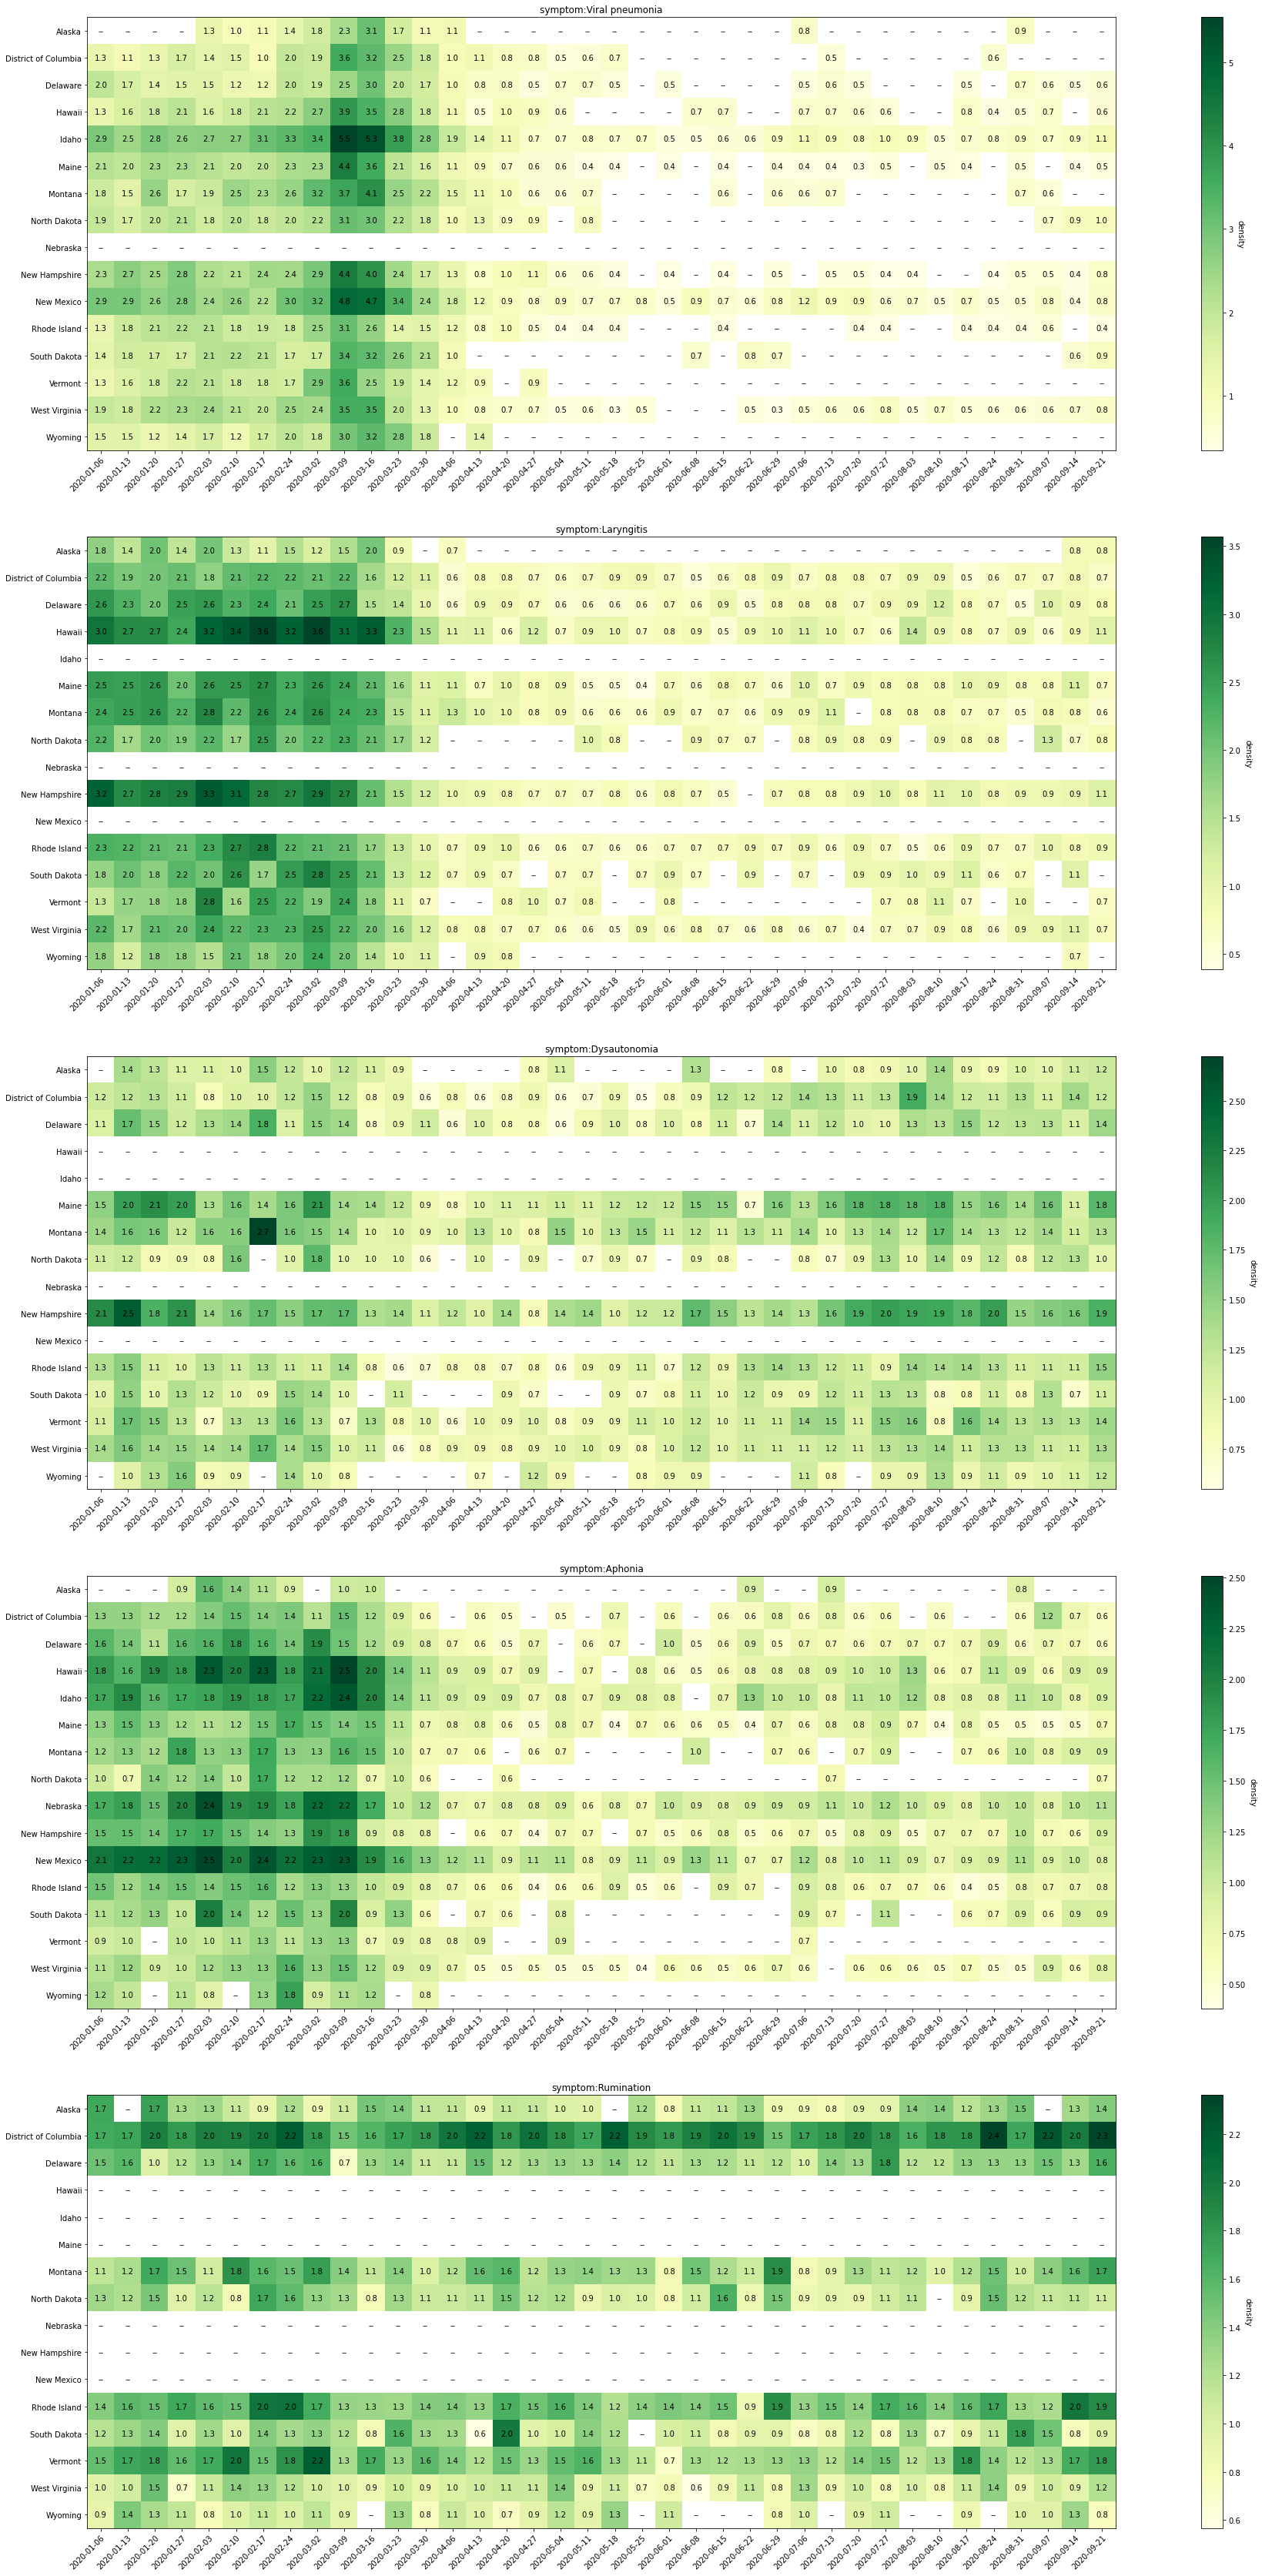

In [339]:
import matplotlib
fig, ax = plt.subplots(5)

for k in range(5):
    z_list=symp[top10[k][0]].values.reshape(16,38)
    
    im, _ = heatmap(z_list, y_index, x_sticks,top10[k][0], ax=ax[k],
                    cmap="YlGn", cbarlabel="density")
    annotate_heatmap(im, valfmt="{x:.1f}", size=60)
fig.tight_layout()
fig.set_size_inches(40, 60)
plt.savefig('heatmap.png')
plt.show()


## task 2.2 PCA

[[0.         0.         0.         ... 0.         1.23029174 0.        ]
 [0.         0.         0.         ... 0.94972067 1.044072   0.        ]
 [0.         0.         0.         ... 0.93606456 2.00993172 0.        ]
 ...
 [0.76013514 0.         1.13513514 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.90540541 0.         0.        ]
 [0.         0.         0.85135135 ... 0.         1.09121622 0.        ]]
[0.43014667 0.24099725 0.07093818 0.05492982 0.04929886 0.02920232
 0.02366178 0.01929553 0.01508278 0.01332913 0.01184351 0.01133424
 0.01079429 0.01046402 0.0086816 ]


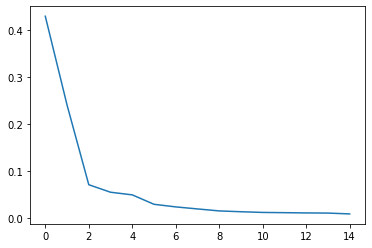

In [1]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
symp = pd.read_csv("clean_search_data.csv")
symp=symp.fillna(0)
x=symp.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values
print(x)
pca=PCA()
pca.fit(x)
x_reduced=pca.transform(x)

#find appropriate value of dimension 
plt.plot(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
#it looks like a decent amount of information was retained by the principal components 1 and 2

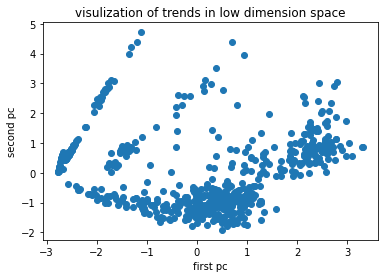

In [2]:
from sklearn.feature_selection import SelectKBest, f_classif
pca=PCA(n_components=6)
#pca.fit(x)
pac_line=pca.fit(x)
pac_line.explained_variance_ratio_
x_reduced=pca.transform(x)
plt.scatter(x_reduced[:,0],x_reduced[:,1])

plt.clim(-0.5,2.5)
plt.xlabel("first pc")
plt.ylabel("second pc")
plt.title("visulization of trends in low dimension space")
plt.savefig('PCA_2pcs.png')

In [3]:
#Task 2.3
# Report why you chose the cluster number K -> at only 5 categories there's already a low number

from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score

sil_high = []
sil_low = []
n_clusters = 20

for cluster in range(2,n_clusters+1):
    print("Number of clusters: ", cluster)
    KMeans_high=KMeans(n_clusters=cluster,random_state=0)
    KMeans_high.fit(x)
    y_pred_high=KMeans_high.predict(x)
    cluster_labels = KMeans_high.fit_predict(x)
    silhouette_avg_high = silhouette_score(x, cluster_labels)
    sil_high.append(silhouette_avg_high)

    print("For", cluster, "clusters,",
          "The average silhouette_score is:", silhouette_avg_high)


    KMeans_low=KMeans(n_clusters=cluster,random_state=0)
    KMeans_low.fit(x_reduced)
    y_pred_low=KMeans_low.predict(x_reduced)
    cluster_labels_low = KMeans_low.fit_predict(x)
    silhouette_avg_low = silhouette_score(x, cluster_labels_low)
    sil_low.append(silhouette_avg_low)

    print("For", cluster, "clusters,",
          "The average silhouette_score is:", silhouette_avg_low)

#choose cluster number=5
print(sil_high)
print(sil_low)




Number of clusters:  2
For 2 clusters, The average silhouette_score is: 0.342366629682567
For 2 clusters, The average silhouette_score is: 0.342366629682567
Number of clusters:  3
For 3 clusters, The average silhouette_score is: 0.3472377943064005
For 3 clusters, The average silhouette_score is: 0.3472377943064005
Number of clusters:  4
For 4 clusters, The average silhouette_score is: 0.3496752352286922
For 4 clusters, The average silhouette_score is: 0.3496752352286922
Number of clusters:  5
For 5 clusters, The average silhouette_score is: 0.3676401784507283
For 5 clusters, The average silhouette_score is: 0.3676401784507283
Number of clusters:  6
For 6 clusters, The average silhouette_score is: 0.30893368028759377
For 6 clusters, The average silhouette_score is: 0.30893368028759377
Number of clusters:  7
For 7 clusters, The average silhouette_score is: 0.3060942507419142
For 7 clusters, The average silhouette_score is: 0.3060942507419142
Number of clusters:  8
For 8 clusters, The ave

Counter({0: 278, 2: 144, 1: 120, 4: 40, 3: 26})
Counter({0: 278, 2: 144, 1: 118, 3: 40, 4: 28})


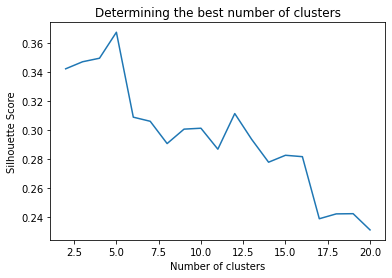

In [4]:
plt.plot(list(range(2, n_clusters+1)), sil_high, label="Sil_high")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Determining the best number of clusters")

KMeans_high=KMeans(n_clusters=5,random_state=0)
KMeans_high.fit(x)
y_pred_high=KMeans_high.predict(x)
    
print(Counter(y_pred_high))

kmeans_low=KMeans(n_clusters=5,random_state=0)
kmeans_low.fit(x_reduced)
y_pred_low=kmeans_low.predict(x_reduced)
   
print(Counter(y_pred_low))

In [171]:

plt.subplot(2,1,1)
#plt.scatter(x[:,0], x[:,1],c=y_pred_high,cmap=plt.cm.get_cmap('viridis',5),s=5)
plt.scatter(x_reduced[:,0], x_reduced[:,1],c=y_pred_high,cmap=plt.cm.get_cmap('viridis',5),s=5)
plt.colorbar(ticks=[0,1,2,3,4])

plt.title("cluster labels for high dimensional KMeans")
plt.tight_layout()

plt.subplot(2,1,2)
plt.scatter(x_reduced[:,0],x_reduced[:,1],c=y_pred_low,cmap=plt.cm.get_cmap('viridis',5),s=5)
plt.colorbar(ticks=[0,1,2,3,4])

plt.title("cluster labels for low dimensional KMeans")
plt.tight_layout()

plt.savefig('cluster.png')


## task 3.1 
    1. KNN
        Select features using impartance
        Select features using recursive feature elimination
            Secon splite on time 
            Secon splite on regions (do cross-validation)


    2. Decision Tree           
        Secon splite on regions (do cross-validation)
                 Select features using importance
                 Select features using recursive feature elimination
        Secon splite on time 
                 Select features using importance
                 Select features using recursive feature elimination

#### Global array to contain all MSE 

In [419]:
MSE_time=[None]*2;
MSE_regions=[None]*2;

In [420]:
import numpy as np
import pandas as pd
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets, neighbors

In [421]:
symp = pd.read_csv("search_and_hosp.csv")
symp=symp.fillna(0)
num_instances=symp.shape[0]
#print(symp.columns.get_loc("symptom:Allergic conjunctivitis"))
x=symp.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values
#print(symp["open_covid_region_code"].unique())
#print(len(symp["open_covid_region_code"].unique()))

(465, 25)
(465, 15) [0.         0.98199876 0.         0.         1.21166977 0.
 1.54562384 0.8777157  0.8777157  1.06517691 1.00310366 1.73432651
 0.         0.         2.34016139]


## Creativity#1: find useful features
You can get the feature importance of each feature of your dataset by using the feature importance property of the model.
Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.
we will be using Extra Tree Classifier for extracting the top 5 features for the dataset.

[0.02723207 0.44016134 0.02104285 0.03307514 0.04291398 0.01867196
 0.02288108 0.08277129 0.01785987 0.03603008 0.04292944 0.01573235
 0.02458614 0.0481984  0.12591401]


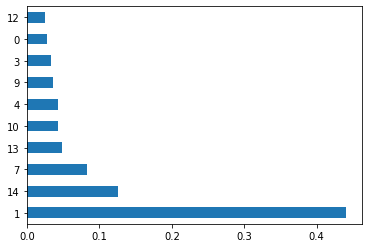

In [571]:
import pandas as pd
import numpy as np
data = pd.read_csv("search_and_hosp.csv")
data=data.fillna(0)
x = data.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values  #independent columns
y = data.loc[:,"hospitalized_new"].values    #target column i.e price range
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [572]:
#selected_index=[5,6,8,11,12]
selected_index=[1,14,7,13,10,4,9,3,0,2]
x_select=x[:,selected_index]
print(x_select.shape)

(465, 10)


In [573]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor

x=symp.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values
model  = DecisionTreeRegressor(random_state=0)
# create the RFE model and select 3 attributes
rfe = RFE(model, 7)
rfe = rfe.fit(x,y)



# summarize the selection of the attributes
selected_features=rfe.support_.tolist()

recursive_index=[]

i=0
print(selected_features)
print(rfe.ranking_)
for f in selected_features:
    #print(selected_features[i])
    if f==True:
        #print("i",i)
        recursive_index.append(i);

    i+=1
print(recursive_index)



[True, True, False, False, True, False, False, True, False, False, True, False, False, True, True]
[1 1 8 7 1 2 9 1 4 5 1 6 3 1 1]
[0, 1, 4, 7, 10, 13, 14]


### selected features:
```<br>
x_recursive: selected by recursive elimination
x_tree_select: selected by extra tree clssifier
```

In [574]:
print(recursive_index,selected_index)
x_recursive=x[:,recursive_index ]
x_tree_select=x[:,selected_index ]
print(x_recursive.shape,x_tree_select.shape)

[0, 1, 4, 7, 10, 13, 14] [1, 14, 7, 13, 10, 4, 9, 3, 0, 2]
(465, 7) (465, 10)


In [575]:
#split based on time, after 2020-08-10

all_col_index=[i for i in range(num_instances)]
valid_date=['2020-08-10', '2020-08-17', '2020-08-24',
 '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21']
train_index=[]
valid_index=[]
for i in all_col_index:
    #print(symp["date"].values[i])
    if symp["date"].values[i] not in valid_date:
        train_index.append(i)
    else:
        valid_index.append(i)

print(len(train_index),len(valid_index))
print(train_index)

353 112
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 

In [576]:
#split the data by date 2020-08-10
#x_all_train, y_all_train are rows before 2020-08-10
#raw data with all features
x_all_train, y_all_train = x[train_index,:], y[train_index]
x_valid,y_valid=x[valid_index,:],y[valid_index]
#features after selection --tree regressor selection
x_train_tree, y_train_tree=x_tree_select[train_index,:], y[train_index]
x_valid_tree,y_valid_tree=x_tree_select[valid_index,:],y[valid_index]
#features after selection-- recursive elmination 
x_train_rec,y_train_rec=x_recursive[train_index,:],y[train_index]
x_valid_rec,y_valid_rec=x_recursive[valid_index,:],y[valid_index]

print(x_valid_rec.shape,y_valid_rec.shape,x_train_rec.shape,y_train_rec.shape)

(112, 7) (112,) (353, 7) (353,)


### KNN-validation test to pick k (time-split)

In [577]:
from sklearn import datasets, neighbors

def KNN_time(K_list,x_all_train,x_valid,y_all_train,y_valid):
    err_train, err_valid ,accuracy_valid,accuracy_train= [], [], [],[]
    for i, K in enumerate(K_list):
        model = neighbors.KNeighborsRegressor(n_neighbors=K)
        model = model.fit(x_all_train, y_all_train)
        err_valid.append(np.mean((model.predict(x_valid) - y_valid)**2))
        err_train.append(np.mean((model.predict(x_all_train) - y_all_train)**2))
        
        accuracy_valid.append(np.sum(model.predict(x_valid) == y_valid)/y_valid.shape[0])
        accuracy_train.append(np.sum(model.predict(x_all_train) == y_all_train)/y_all_train.shape[0])
        
    plt.plot(K_list, err_valid, label='validation')

    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('mean squared error')
    plt.savefig("KNN_time_solo.png")
    plt.show()

    return err_train, err_valid ,accuracy_valid,accuracy_train




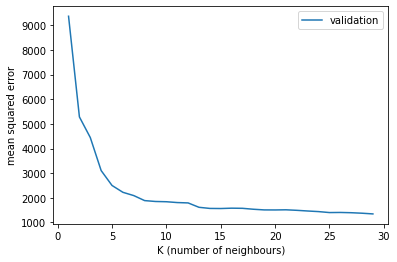

[0.22321428571428573, 0.15178571428571427, 0.13392857142857142, 0.13392857142857142, 0.11607142857142858, 0.09821428571428571, 0.08928571428571429, 0.05357142857142857, 0.026785714285714284, 0.026785714285714284, 0.017857142857142856, 0.008928571428571428, 0.008928571428571428, 0.008928571428571428, 0.008928571428571428, 0.008928571428571428, 0.008928571428571428, 0.008928571428571428, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
18
Valid MSE: 1510.64
Valid Accuracy: 0.00 


In [578]:

K_list = range(1,30)
err_train, err_valid ,accuracy_valid,accuracy_train=KNN_time(K_list,x_all_train,x_valid,y_all_train,y_valid)
print(accuracy_valid)
print(accuracy_valid.index(min(accuracy_valid)))
print("Valid MSE: %0.2f" % (err_valid[18]))
print("Valid Accuracy: %0.2f " % (accuracy_valid[18]))



In [515]:
# MSE of time-split KNN, K=28
print("KNN Time split Valid MSE: %0.2f" % (err_valid[18]))


Valid MSE: 1510.64


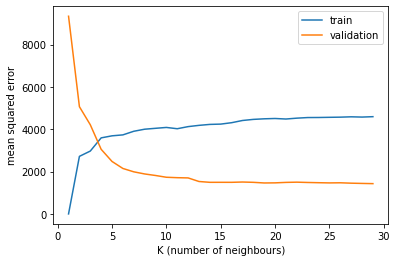

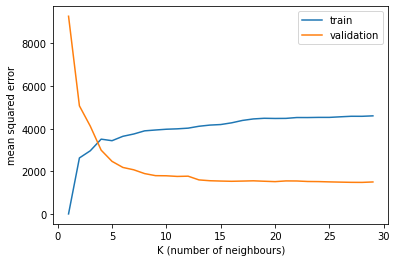

In [516]:

err_train_rec, err_valid_rec ,accuracy_valid_rec,accuracy_train_rec=KNN_time(K_list,x_train_rec,x_valid_rec,y_train_rec,y_valid_rec)
err_train_tree, err_valid_tree ,accuracy_valid_tree,accuracy_train_tree=KNN_time(K_list,x_train_tree,x_valid_tree,y_train_tree,y_valid_tree)

In [517]:
def compare_err(K_list,err_valid,err_valid_select,accuracy_valid,accuracy_valid_select):
    plt.plot(K_list, err_valid,  label='raw')
    plt.plot(K_list, err_valid_select, label='selected')

    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('mean squared error')
    plt.savefig('knn_compare_MSE.png')

    plt.show()


    


In [533]:

#compare_err(K_list,err_valid, err_valid_select ,accuracy_valid,accuracy_valid_select)

KT_raw_means=np.mean(err_valid)
KT_rec_means=np.mean(err_valid_rec)
KT_tree_means=np.mean(err_valid_tree)
print(KT_raw_means,KT_rec_means,KT_tree_means)
print(err_valid[5],err_valid_rec[5],err_valid_tree[5])
KNN_time_performance=[KT_raw_means,KT_rec_means,KT_tree_means]
KNN_time_spot=[err_valid[18],err_valid_rec[18],err_valid_tree[18]]
print(KNN_time_spot)
MSE_time[0]=KNN_time_spot
#difference=(raw_means-select_means)/raw_means*100
#print("after selecting the 12 most useful features,the MSE decrease by "+ str(round(difference[0],2))）

2190.6246439372153 2147.7444899237275 2176.8130809095273
2224.9605654761904 2147.217261904762 2180.357638888889
[1510.6366244558765, 1462.2462900672733, 1532.917120102889]


### KNN region-split: Cross-validation

In [519]:
symp = pd.read_csv("search_and_hosp.csv")
symp=symp.fillna(0)
print(symp.shape)
num_instances=symp.shape[0]
x=symp.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values
print(x.shape,x[0])


(465, 25)
(465, 15) [0.         0.98199876 0.         0.         1.21166977 0.
 1.54562384 0.8777157  0.8777157  1.06517691 1.00310366 1.73432651
 0.         0.         2.34016139]


In [520]:

all_col_index=[i for i in range(num_instances)]
unique_region=[]
for x in symp["open_covid_region_code"].unique():
    unique_region.append(x)
#block_index: list of list, each list is the indices of rows in the same region 
block_index=[]
for label in unique_region:
    block=[]
    for i in all_col_index:
        if symp["open_covid_region_code"].values[i] ==label:
            block.append(i)
    block_index.append(block)

print(len(block_index))

16


In [521]:
inds = np.random.permutation(num_instances)
print(symp.columns)
x=symp.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values
y=symp.loc[:,'hospitalized_new'].values
#predict the first region, training on the rest 15(?)
print(selected_index)

rest= sum(block_index, [])
x_rest, y_rest = x[rest], y[rest]
x_rest_tree,y_rest_tree=x_tree_select[rest],y[rest]
x_rest_rec,y_rest_rec=x_recursive[rest],y[rest]
n_rest = num_instances - len(rest)
print(x_rest_tree.shape,selected_index,y_rest_tree.shape)

Index(['Unnamed: 0', 'open_covid_region_code', 'country_region_code',
       'country_region', 'sub_region_1', 'sub_region_1_code', 'sub_region_2',
       'sub_region_2_code', 'date', 'symptom:Angular cheilitis',
       'symptom:Aphonia', 'symptom:Burning Chest Pain', 'symptom:Crackles',
       'symptom:Dysautonomia', 'symptom:Hemolysis', 'symptom:Laryngitis',
       'symptom:Myoclonus', 'symptom:Rectal pain', 'symptom:Rumination',
       'symptom:Shallow breathing', 'symptom:Stridor',
       'symptom:Urinary urgency', 'symptom:Ventricular fibrillation',
       'symptom:Viral pneumonia', 'hospitalized_new'],
      dtype='object')
[1, 14, 7, 13, 10, 4, 9, 3, 0, 2]
(465, 10) [1, 14, 7, 13, 10, 4, 9, 3, 0, 2] (465,)


In [522]:


def cross_validate(n, block_index,n_folds=10):
    n_val = n // n_folds #floor divison, e.g. 15//2=7
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        tr_blk=[]
        val_blk=[]
        val_inds = list(range(f * n_val, (f+1)*n_val))
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        for i in tr_inds:
            tr_blk.append(block_index[i])
            #print("tr",tr_blk)
        tr_blk=sum(tr_blk,[])
        #print("after",tr_blk)
        for j in val_inds:
            val_blk.append(block_index[j])
        val_blk=sum(val_blk,[])
        yield tr_blk, val_blk

In [523]:

def KNN_region(num_folds,K_list,cross_validate,block_index,x_rest,y_rest):
    err_valid = np.zeros((len(K_list), num_folds))
    accuracy=np.zeros((len(K_list),num_folds))
    loss = lambda y, yh: np.mean(np.square(np.absolute(y-yh)))
    for i, K in enumerate(K_list):#try all possible k values
        for f, (tr, val) in enumerate(cross_validate(15, block_index,num_folds)):
            model = neighbors.KNeighborsRegressor(n_neighbors=K)
            
            
            model = model.fit(x_rest[tr], y_rest[tr])
            err_valid[i, f] = loss(y_rest[val], model.predict(x_rest[val]))
            accuracy[i,f]=np.sum(model.predict(x_rest[val]) == y_rest[val])/y_rest[val].shape[0]

    

    plt.errorbar(K_list, np.mean(err_valid, 1), np.std(err_valid, 1), label='validation')
    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('mean squared error')
    plt.savefig("KNN_region_solo.png")
    plt.show()  
    return err_valid,accuracy


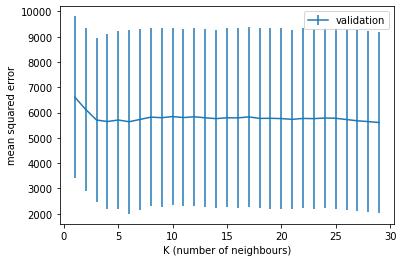

(array([28]),)


In [524]:
num_folds = 5
K_list=range(1,30)
raw_err_valid,raw_accuracy=KNN_region(num_folds,K_list,cross_validate,block_index,x_rest,y_rest)
raw_err_valid_mean=np.mean(raw_err_valid,1)
print(np.where(raw_err_valid_mean==(min(raw_err_valid_mean))))


In [525]:
#region_split KNN MSE， k=5
#select by simplest model within 1 std from min validation error
raw_accuracy_mean=np.mean(raw_accuracy,1)
print("Valid MSE: %0.2f" % (raw_err_valid_mean[28]))


Valid MSE: 5605.54


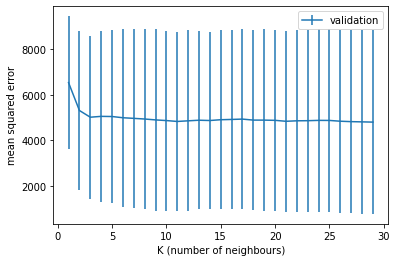

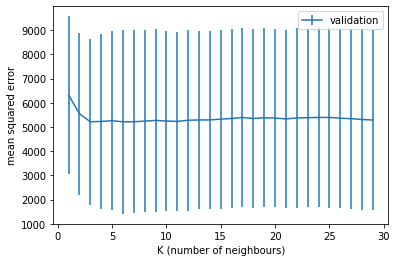

In [530]:
num_folds = 5
K_list=range(1,30)
rec_err_valid,rec_accuracy=KNN_region(num_folds,K_list,cross_validate,block_index,x_rest_rec,y_rest_rec)
tree_err_valid,tree_accuracy=KNN_region(num_folds,K_list,cross_validate,block_index,x_rest_tree,y_rest_tree)
rec_err_valid_mean=np.mean(rec_err_valid,1)
tree_err_valid_mean=np.mean(tree_err_valid,1)

In [527]:
def compare_error_cross(K_list,raw_err_valid, select_err_valid):
    plt.errorbar(K_list, np.mean(raw_err_valid, 1), np.std(raw_err_valid, 1), label='raw')
    plt.errorbar(K_list, np.mean(select_err_valid, 1), np.std(select_err_valid, 1), label='select')
    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('mean squared error') 
    plt.savefig('knn_region_compare_MSE.png')
    plt.show() 
#show the MSE and accuracy increase if we remove some features
#compare_error_cross(K_list,raw_err_valid, select_err_valid)
#compare_error_cross(K_list,raw_accuracy, select_accuracy)
raw_means=np.mean(raw_err_valid)
rec_means=np.mean(rec_err_valid)
tree_means=np.mean(tree_err_valid)
print(raw_means,rec_means,tree_means)



5791.982781010694 4972.668627134401 5351.011303730467


In [534]:
KNN_region_performance=[raw_means,rec_means,tree_means]
KNN_spot_performance=[raw_err_valid_mean[28],rec_err_valid_mean[28],tree_err_valid_mean[28]]
print(KNN_spot_performance)
MSE_regions[0]=KNN_spot_performance
print(MSE_time,MSE_regions)

[5605.5383072286695, 4805.649412893543, 5285.448017517834]
[[1510.6366244558765, 1462.2462900672733, 1532.917120102889], [6432.883928571428, 2906.694223985891, 6012.276785714285]] [[5605.5383072286695, 4805.649412893543, 5285.448017517834], [15285.939315569489, 13951.41272204807, 14811.747622779521]]


## Task3.2 Decision Tree

### splite the date based on regions

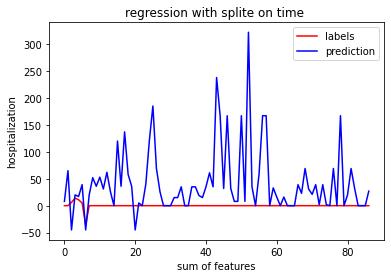

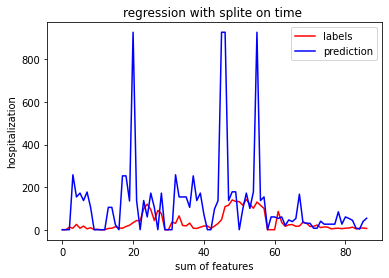

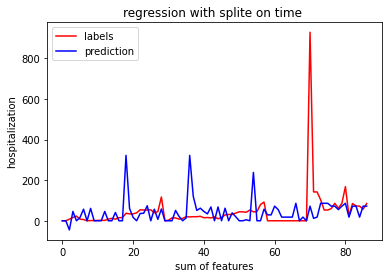

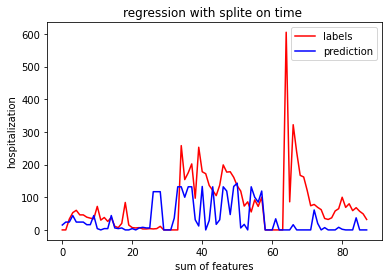

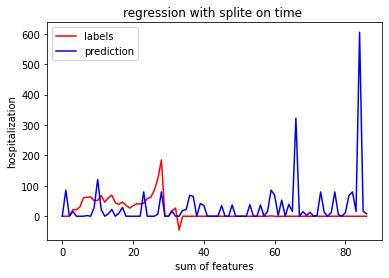

In [551]:
#split by regions 80% training and 20% test
from sklearn import tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score

symp = pd.read_csv("search_and_hosp.csv")
symp=symp.fillna(0)
x=symp.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values
y=symp.loc[:,'hospitalized_new'].values

x_select=x[:,selected_index]
rest= sum(block_index, [])
x_rest, y_rest = x[rest], y[rest]
x_rest_select,y_rest_select=x_select[rest],y[rest]

def tree_cv(num_folds,cross_validate,block_index,x_rest,y_rest):
    err_valid = np.zeros(( num_folds))
    accuracy=np.zeros((num_folds))
    loss = lambda y, yh: np.mean(np.square(np.absolute(y-yh)))
    for f, (tr, val) in enumerate(cross_validate(15, block_index,num_folds)):
        model  = DecisionTreeRegressor(random_state=0)

       
        
        model = model.fit(x_rest[tr], y_rest[tr])
        err_valid[f] = loss(y_rest[val], model.predict(x_rest[val]))
        accuracy[f]=np.sum(model.predict(x_rest[val]) == y_rest[val])/y_rest[val].shape[0]

        output = model.predict(x_rest[val]) #predicted labels 
        plt.plot(y_rest[val], color = 'red', label="labels")
        plt.plot(output, color = 'blue', label="prediction")
        plt.legend()
        plt.title('regression with splite on time ')
        plt.xlabel('sum of features')
        plt.ylabel('hospitalization')
        plt.show()

    return err_valid,accuracy

num_folds = 5
K_list=range(1,30)
raw_err_valid,raw_accuracy=tree_cv(num_folds,cross_validate,block_index,x,y_rest)
raw_err_valid_mean=np.mean(raw_err_valid)





MSE accuracy of region split Decision Tree

In [552]:
#region_split decision tree MSE and accuracy, k=5
raw_accuracy_mean=np.mean(raw_accuracy)
tree_region_performance=[]
tree_region_performance.append(raw_err_valid_mean)
print("Valid MSE: %0.2f" % (raw_err_valid_mean))
print (tree_region_performance)


Valid MSE: 15285.94
[15285.939315569489]


### select based on importance of the feature (splite on region)

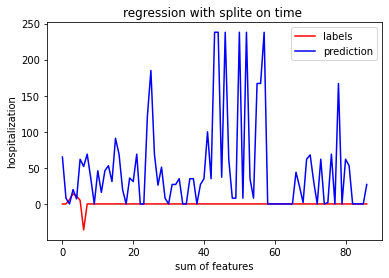

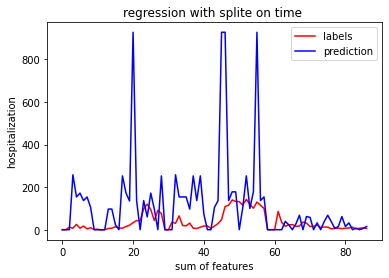

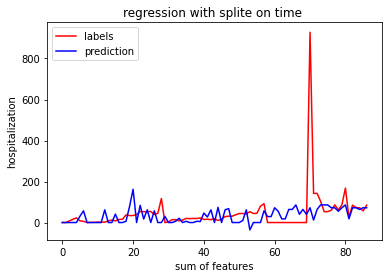

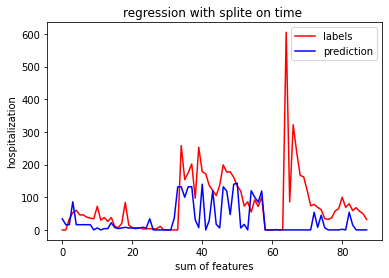

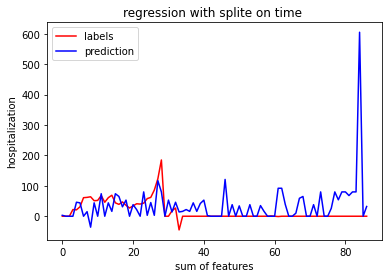

In [553]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(x_rest, y)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
x_rest_new = model.transform(x_rest)

raw_err_valid,raw_accuracy=tree_cv(num_folds,cross_validate,block_index,x_tree_select,y_rest)

Accuracy after select features use filter-based feature selections

In [554]:
#region_split decision tree MSE
raw_err_valid_mean=np.mean(raw_err_valid)


raw_accuracy_mean=np.mean(raw_accuracy)
tree_region_performance.insert(2, raw_err_valid_mean)   
print("Valid MSE: %0.2f" % (raw_err_valid_mean))
print (tree_region_performance)

Valid MSE: 14811.75
[15285.939315569489, 14811.747622779521]


[True, True, False, False, True, False, False, True, False, False, True, False, False, True, True]
[1 1 8 7 1 2 9 1 4 5 1 6 3 1 1]
[0, 1, 4, 7, 10, 13, 14]


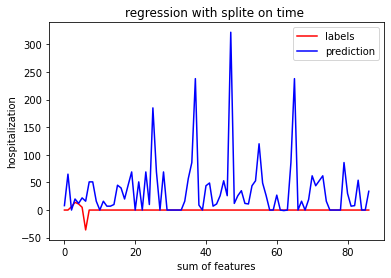

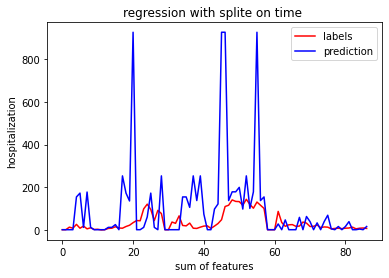

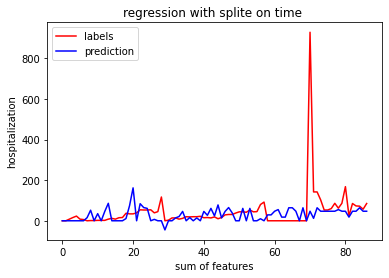

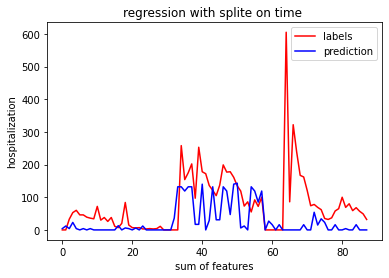

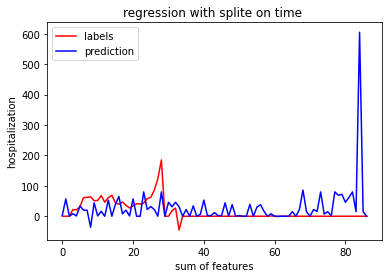

In [555]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

x=symp.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values
x_select=x[:,selected_index]
rest= sum(block_index, [])
x_rest, y_rest = x[rest], y[rest]

model  = DecisionTreeRegressor(random_state=0)
# create the RFE model and select 3 attributes
rfe = RFE(model, 7)
rfe = rfe.fit(x_rest, y_rest)



# summarize the selection of the attributes
selected_features=rfe.support_.tolist()

index=[]

i=0
print(selected_features)
print(rfe.ranking_)
for f in selected_features:
    if f==True:
        index.append(i);

    i+=1
print(index)

x_rest=x_rest [:,index ]
raw_err_valid,raw_accuracy=tree_cv(num_folds,cross_validate,block_index,x_recursive,y_rest)



Accuracy after select features use RFE

In [556]:
#region_split decision tree MSE and accuracy, k=5
raw_err_valid_mean=np.mean(raw_err_valid)

raw_accuracy_mean=np.mean(raw_accuracy)
tree_region_performance.insert(1, raw_err_valid_mean) 
print("Valid MSE: %0.2f" % (raw_err_valid_mean))
print (tree_region_performance)

MSE_regions[1]=tree_region_performance
print (MSE_regions[1])

Valid MSE: 13951.41
[15285.939315569489, 13951.41272204807, 14811.747622779521]
[15285.939315569489, 13951.41272204807, 14811.747622779521]


### feature selection (Split based on time)

In [557]:
#split the data by date 2020-08-10
from sklearn import tree
from sklearn import metrics 
import pandas as pd

symp = pd.read_csv("search_and_hosp.csv")
symp=symp.fillna(0)
print(symp.shape)
num_instances=symp.shape[0]
x=symp.iloc[:, 7:-1].values
y=symp["hospitalized_new"].values
print(x.shape,x[0])
print(symp["open_covid_region_code"].unique())
print(len(symp["open_covid_region_code"].unique()))

(465, 25)
(465, 17) [0.0 '2020-03-09' 0.0 0.9819987585350716 0.0 0.0 1.2116697703289885 0.0
 1.5456238361266297 0.8777157045313471 0.8777157045313471
 1.0651769087523275 1.0031036623215397 1.7343265052762258 0.0 0.0
 2.3401613904407204]
['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE'
 'US-NH' 'US-NM' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']
16


In [558]:
#split based on time, after 2020-08-10

all_col_index=[i for i in range(num_instances)]
test_date=['2020-08-10', '2020-08-17', '2020-08-24',
 '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21']
train_index=[]
test_index=[]
for i in all_col_index:
    if symp["date"].values[i] not in test_date:
        train_index.append(i)
    else:
        test_index.append(i)

print(len(train_index),len(test_index))
print(train_index)

353 112
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 

In [559]:
#split the data by date 2020-08-10
#x_all_train, y_all_train are rows before 2020-08-10
x=symp.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values
x_all_train, y_all_train = x[train_index,:], y[train_index]
x_test,y_test=x[test_index,:],y[test_index]

Valid MSE: 6432.88


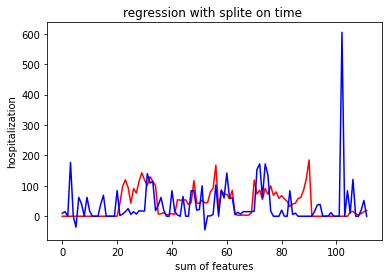

[6432.883928571428]


In [560]:

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(x_all_train, y_all_train)
score= regressor.score(x_test, y_test)


#calcuate mse
output = regressor.predict(x_test) #predicted labels 
mse=metrics.mean_squared_error(y_test,output)

#calcuate accuracy
#accuracy=metrics.accuracy_score(y_test, output)
print("Valid MSE: %0.2f" % (mse))

#print("Valid Accuracy: %0.2f" % (accuracy))

plt.plot(y_test, color = 'red')
plt.plot(output, color = 'blue')
plt.title('regression with splite on time ')
plt.xlabel('sum of features')
plt.ylabel('hospitalization')
plt.show()
tree_time_performance=[]
tree_time_performance.append(mse)

print(tree_time_performance)
y_test_nonselect=y_test
output_nonselect=output



### feature selection (split on feature importance)

Valid MSE: 2906.69


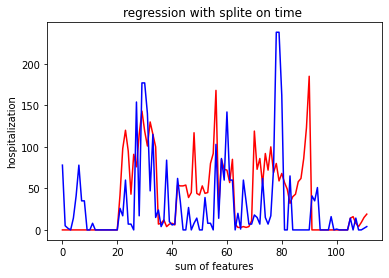

[6432.883928571428, 2906.694223985891]


In [561]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(x, y)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
x_new = model.transform(x)
x=symp.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values

x=x_new
x_all_train, y_all_train = x[train_index,:], y[train_index]
x_test,y_test=x[test_index,:],y[test_index]
regressor.fit(x_all_train, y_all_train)
#calcuate mse
output = regressor.predict(x_test) #predicted labels 
mse=metrics.mean_squared_error(y_test,output)

#calcuate accuracy

#Accuracy=r2_score(y_test,output)
print("Valid MSE: %0.2f" % (mse))

plt.plot(y_test,color="red")

plt.plot(output,color="blue")


plt.title('regression with splite on time ')
plt.xlabel('sum of features')
plt.ylabel('hospitalization')
plt.show()


tree_time_performance.insert(1,mse)

print(tree_time_performance)

### feature selection RFE (split on time)

[False, True, False, True, True, False, False, True, False, True, False, False, True, False, True]
[5 1 6 1 1 4 9 1 7 1 3 2 1 8 1]
[1, 3, 4, 7, 9, 12, 14]
Valid MSE: 6012.28
[6432.883928571428, 2906.694223985891, 6012.276785714285]


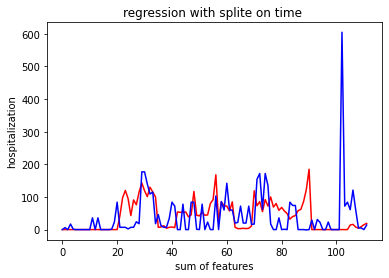

In [562]:
model  = DecisionTreeRegressor(random_state=0)
# create the RFE model and select 3 attributes
rfe = RFE(model, 7)
#split the data by date 2020-08-10
#x_all_train, y_all_train are rows before 2020-08-10
x=symp.loc[:,'symptom:Angular cheilitis':'symptom:Viral pneumonia'].values
y=symp["hospitalized_new"].values
x_all_train, y_all_train = x[train_index,:], y[train_index]
x_test,y_test=x[test_index,:],y[test_index]
rfe = rfe.fit(x_all_train, y_all_train)


 
# summarize the selection of the attributes
selected_features=rfe.support_.tolist()

index=[]
i=0
print(selected_features)
print(rfe.ranking_)
for f in selected_features:
    #print(selected_features[i])
    if f==True:
        index.append(i);

    i+=1
print(index)

x_all_train=x_all_train [:,index ]
x_test=x_test[:,index ]

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(x_all_train, y_all_train)



#calcuate mse
output = regressor.predict(x_test) #predicted labels 
mse=metrics.mean_squared_error(y_test,output)

#calcuate accuracy
#accuracy=metrics.accuracy_score(y_test, output)
print("Valid MSE: %0.2f" % (mse))
tree_time_performance.insert(2,mse)
print(tree_time_performance)

MSE_time[1]=tree_time_performance


plt.plot(y_test,color="red")
plt.plot(output,color="blue")


plt.title('regression with splite on time ')
plt.xlabel('sum of features')
plt.ylabel('hospitalization')
plt.show()


## Bar diagram to compare KNN-decision tree's MSE (Comparision)

[[1510.6366244558765, 1462.2462900672733, 1532.917120102889], [6432.883928571428, 2906.694223985891, 6012.276785714285]]
[[5605.5383072286695, 4805.649412893543, 5285.448017517834], [15285.939315569489, 13951.41272204807, 14811.747622779521]]


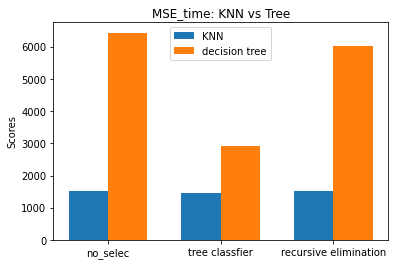

In [580]:
print (MSE_time)
print (MSE_regions)



import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['no_selec', 'tree classfier', 'recursive elimination']
width = 0.35  # the width of the bars
x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, MSE_time[0], width, label='KNN')
rects2 = ax.bar(x + width/2, MSE_time[1], width, label='decision tree')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('MSE_time: KNN vs Tree')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig("MSE_time:KNN VS TREE")
plt.show()

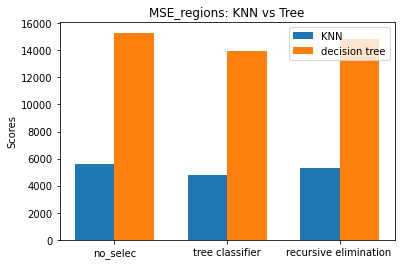

In [579]:
labels = ['no_selec', 'tree classifier', 'recursive elimination ']
width = 0.35  # the width of the bars
x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, MSE_regions[0], width, label='KNN')
rects2 = ax.bar(x + width/2, MSE_regions[1], width, label='decision tree')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('MSE_regions: KNN vs Tree')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
plt.savefig("MSE_regions:KNN vs TREE")
plt.show()

In [485]:
print(MSE_regions[0],MSE_time[0])
KNN_means=np.array([MSE_regions[0],MSE_time[0]]).T
print(KNN_means)
TREE_means=np.array([MSE_regions[1],MSE_time[1]]).T

[5791.982781010694, 4972.668627134401, 5351.011303730467] [2190.6246439372153, 2147.7444899237275, 2176.8130809095273]
[[5791.98278101 2190.62464394]
 [4972.66862713 2147.74448992]
 [5351.01130373 2176.81308091]]


In [503]:
print(MSE_regions,MSE_time)


labels = ['time_split','region_split']
def compare_selection(labels,input_means):
    raw_means = input_means[0]
    rec_means = input_means[1]
    tree_means=input_means[2]
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x+0.00,raw_means, width=0.25, label='raw')
    rects2 = ax.bar(x+0.25, rec_means, width=0.25, label='recursive elimination')
    rects3 = ax.bar(x+0.50, tree_means, width, label='tree classifier')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MSE')
    ax.set_title('Performance Improvement')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
    
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.savefig("tree_selection_compare.png")

    plt.show()
    


[[5791.982781010694, 4972.668627134401, 5351.011303730467], [15285.939315569489, 13951.41272204807, 14811.747622779521]] [[2190.6246439372153, 2147.7444899237275, 2176.8130809095273], [6432.883928571428, 2906.694223985891, 6012.276785714285]]


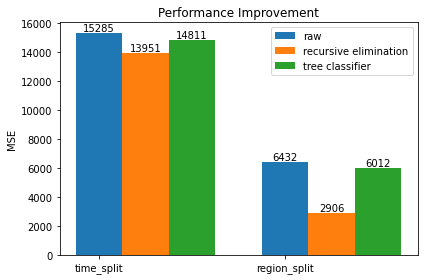

In [504]:
compare_selection(labels,TREE_means)
